# Preprocessing Pipeline

In [29]:
### imports base

import pandas as pd
import numpy as np
from scipy import stats

### imports analysis

import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

### imports preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler,
                                   FunctionTransformer, PolynomialFeatures, Normalizer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn import set_config
set_config(transform_output='pandas')

### set up system path to access helpers functions

import sys, os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
  sys.path.append(src_path)

# import helpers
from helpers import *


In [30]:
### import class balancers

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

### import classifier models

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance
import shap


In [31]:
# import merged data

df = pd.read_csv('../data/merged_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Feature Cleaning

In [32]:
# replace DAYS_EMPLOYED's placeholder value of 365243 with 365

def clean_days_employed(X):
  X['DAYS_EMPLOYED'] = X['DAYS_EMPLOYED'].replace(365243, 365)
  return X

preprocessor_days_employed = FunctionTransformer(clean_days_employed)

# Drop Outliers

In [33]:
# define the outlier remover custom transformer imported from src.helpers

outlier_remover = OutlierRemover(columns=[], iqr_multiplier=5)

# list the features to remove outliers from

outlier_cols = []

# create the preprocessor

preprocessor_outliers = ColumnTransformer([
  ('outlier_remover', outlier_remover, outlier_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Feature Filter

In [34]:
# create a list of the feature to keep

cols_original_keep = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL',
             'AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
             'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED',
             'DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL',
             'OCCUPATION_TYPE','CNT_FAM_MEMBERS','REGION_RATING_CLIENT','WEEKDAY_APPR_PROCESS_START',
             'HOUR_APPR_PROCESS_START','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
             'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']

cols_engineered_keep = ['num_bureau_records','num_active_bureau_credits','num_closed_bureau_credits','num_bad_bureau_credits',
                        'num_sold_bureau_credits','avg_ratio_bureau_cr_debt','ttl_bureau_cc_limit','ttl_bureau_credit_overdue',
                        'cc_avg_credit_usage_ratio','avg_cc_ATM_ratio','avg_cc_cnt_ATM_drawings','avg_cc_DPD','avg_cc_DPD_DEF',
                        'prev_avg_ratio_credit_approved',
                        'prev_reject_CLIENT','prev_reject_HC','prev_reject_LIMIT','prev_reject_SCO','prev_reject_SCOFR',
                        'prev_reject_SYSTEM','prev_reject_VERIF','prev_reject_XAP','prev_reject_XNA',
                        'prev_status_approved','prev_status_canceled','prev_status_refused','prev_status_unused',
                        'prev_yield_XNA','prev_yield_high','prev_yield_low_action','prev_yield_low_normal',
                        'prev_yield_middle','prev_insured','prev_contract_type_cash','prev_contract_type_consumer',
                        'prev_contract_type_revolving','prev_contract_type_XNA',
                        'prev_client_type_repeater','prev_client_type_new','prev_client_type_refreshed']

cols_original_2_keep = ['DAYS_LAST_PHONE_CHANGE','FLAG_DOCUMENT_3',
                        'FLAG_DOCUMENT_13','FLAG_DOCUMENT_16','FLAG_DOCUMENT_18',
                        'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR',
                        'EXT_SOURCE_2','EXT_SOURCE_1','EXT_SOURCE_3'
                        ]

cols_keep = cols_original_keep + cols_engineered_keep + cols_original_2_keep

In [35]:
# create a column transformer to filter unwanted columns

preprocessor_filter = ColumnTransformer([
  ('passthrough', 'passthrough', cols_keep)
], remainder='drop', verbose_feature_names_out=False)

# Imputing

In [36]:
# list the imputing features

impute_freq_cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                    'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START',
                    'FLAG_OWN_CAR','FLAG_OWN_REALTY']
impute_zero_cols = ['CNT_CHILDREN','num_bureau_records',
                    'num_active_bureau_credits','num_closed_bureau_credits','num_bad_bureau_credits',
                    'num_sold_bureau_credits','avg_ratio_bureau_cr_debt','ttl_bureau_cc_limit','ttl_bureau_credit_overdue',
                    'cc_avg_credit_usage_ratio','avg_cc_ATM_ratio','avg_cc_cnt_ATM_drawings','avg_cc_DPD','avg_cc_DPD_DEF',
                    'prev_reject_CLIENT','prev_reject_HC','prev_reject_LIMIT','prev_reject_SCO','prev_reject_SCOFR',
                    'prev_reject_SYSTEM','prev_reject_VERIF','prev_reject_XAP','prev_reject_XNA']
impute_none_cols = ['OCCUPATION_TYPE']
impute_median_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                      'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE',
                      'FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','REGION_RATING_CLIENT',
                      'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                      'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','HOUR_APPR_PROCESS_START',
                      'CNT_FAM_MEMBERS','prev_avg_ratio_credit_approved',
                      'prev_status_approved','prev_status_canceled','prev_status_refused','prev_status_unused',
                      'prev_yield_XNA','prev_yield_high','prev_yield_low_action','prev_yield_low_normal',
                      'prev_yield_middle','prev_insured','prev_contract_type_cash','prev_contract_type_consumer',
                      'prev_contract_type_revolving','prev_contract_type_XNA',
                      'prev_client_type_repeater','prev_client_type_new','prev_client_type_refreshed',
                      'DAYS_LAST_PHONE_CHANGE','FLAG_DOCUMENT_3','FLAG_DOCUMENT_13','FLAG_DOCUMENT_16','FLAG_DOCUMENT_18',
                      'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','EXT_SOURCE_2',
                      'EXT_SOURCE_1','EXT_SOURCE_3']


# assemble the preprocess

preprocessor_imputing = ColumnTransformer([
  ('impute_most_frequent', SimpleImputer(strategy='most_frequent'), impute_freq_cols),
  ('impute_zero', SimpleImputer(strategy='constant', fill_value=0), impute_zero_cols),
  ('impute_none', SimpleImputer(strategy='constant', fill_value='None'), impute_none_cols),
  ('impute_median', SimpleImputer(strategy='median'), impute_median_cols)
], remainder='passthrough', verbose_feature_names_out=False)


# Encoding

In [37]:
# define the encoders

ohe = OneHotEncoder(drop='if_binary', min_frequency=100, sparse_output=False)

# list the encoding features

ohe_cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START']

# assemble the preprocessor

preprocessor_encoding = ColumnTransformer([
  ('ohe', ohe, ohe_cols),
], remainder='passthrough', verbose_feature_names_out=False)

# Log Transform

In [38]:
# list the log features

log_transform_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS']

# create a function transformer to do log transformation

def log_transform_df(X):
  return np.log1p(X)

log_transformer = FunctionTransformer(log_transform_df)


# define the preprocessor

preprocessor_log = ColumnTransformer([
  ('log_transformer', log_transformer, log_transform_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Scaling

In [39]:
# list the scaling features

standard_scaler_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_BIRTH',
                        'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',
                        'HOUR_APPR_PROCESS_START']

# assemble the preprocessor

preprocessor_scaling = ColumnTransformer([
  ('StandardScaler', StandardScaler(), standard_scaler_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Train-test-split

In [40]:
# train-test-split

X = df.drop(columns=['SK_ID_CURR','TARGET'])
y = df['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pipeline

In [41]:
# define the main pipe

main_pipe = Pipeline([('preprocessor_days_employed', preprocessor_days_employed),
                      ('preprocessor_filter', preprocessor_filter),
                      ('preprocessor_outliers',preprocessor_outliers),
                      ('preprocessor_imputing', preprocessor_imputing),
                      ('preprocessor_encoding', preprocessor_encoding),
                      ('preprocessor_log', preprocessor_log),
                      ('preprocessor_scaling', preprocessor_scaling)
                      ])

In [42]:
# check the pipe

main_pipe

Pipeline(steps=[('preprocessor_days_employed',
                 FunctionTransformer(func=<function clean_days_employed at 0x1386e6480>)),
                ('preprocessor_filter',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'N...
                ('preprocessor_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEMBERS',
                                                   'REGION_RATING_CLIENT',
                                                   'HOUR_APPR_PROCESS_START'])],
                                   verbose_feature_names_out=False))])

# Modeling

### 1. Logistic Regression - Undersampling

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.58      0.72    226148
           1       0.13      0.70      0.22     19860

    accuracy                           0.59    246008
   macro avg       0.54      0.64      0.47    246008
weighted avg       0.89      0.59      0.68    246008



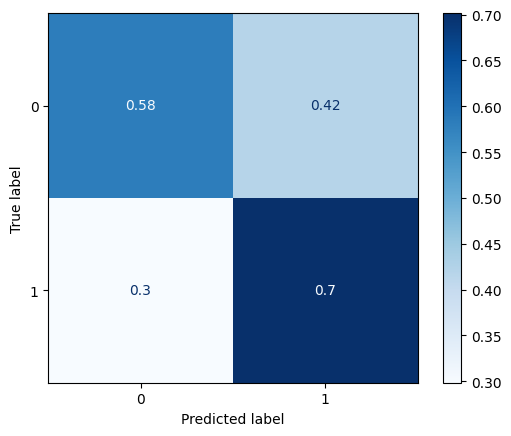

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     56538
           1       0.13      0.71      0.22      4965

    accuracy                           0.59     61503
   macro avg       0.54      0.65      0.47     61503
weighted avg       0.89      0.59      0.69     61503



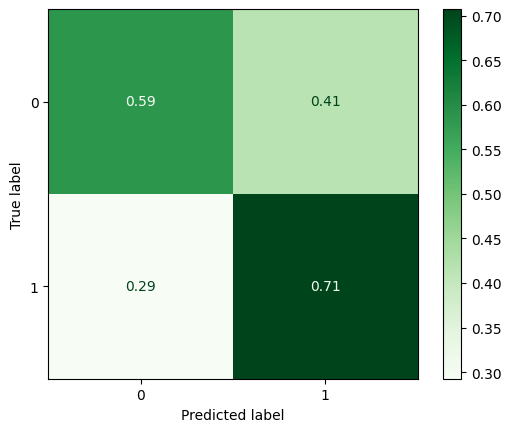

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.590936,0.594963,0.12825,0.130219,0.701561,0.707351,0.216858,0.219947,0.693859,0.698085


In [43]:
# define pipeline for LR
estimators = [step[1] for step in main_pipe.steps]

lr_pipe = make_pipeline(*estimators, RandomUnderSampler(), LogisticRegression(max_iter=1000))

# check the results

model_results,train_pred,test_pred = eval_classification(lr_pipe, X_train, y_train, X_test, y_test, model_name='LR undersampling', pos_label=1)
model_results

### 2. Logistic Regression - Weighted

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.61      0.74    226148
           1       0.13      0.68      0.22     19860

    accuracy                           0.61    246008
   macro avg       0.54      0.64      0.48    246008
weighted avg       0.89      0.61      0.70    246008



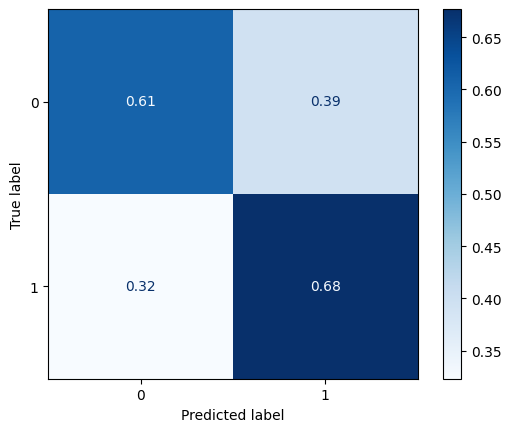

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.61      0.75     56538
           1       0.13      0.68      0.22      4965

    accuracy                           0.62     61503
   macro avg       0.54      0.65      0.48     61503
weighted avg       0.89      0.62      0.70     61503



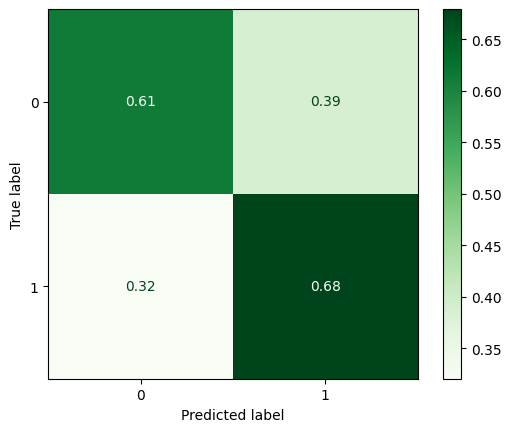

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.590936,0.594963,0.128250,0.130219,0.701561,0.707351,0.216858,0.219947,0.693859,0.698085
LR balanced,0.613078,0.617905,0.131521,0.133420,0.676888,0.679355,0.220247,0.223038,0.692880,0.697400


In [44]:
# define pipeline for LR with weighted classes

estimators = [step[1] for step in main_pipe.steps]

lr_pipe = make_pipeline(*estimators, LogisticRegression(max_iter=1000, class_weight='balanced'))

# check the results

model_results,train_pred,test_pred = eval_classification(lr_pipe, X_train, y_train, X_test, y_test, model_name='LR balanced', pos_label=1,
                                    results_frame=model_results)
model_results

### 3. DecisionTree

Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.67      0.79    226148
           1       0.15      0.68      0.25     19860

    accuracy                           0.67    246008
   macro avg       0.56      0.67      0.52    246008
weighted avg       0.89      0.67      0.74    246008



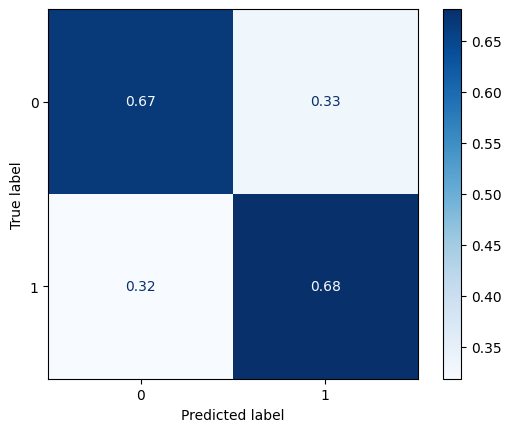

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.67      0.78     56538
           1       0.15      0.66      0.24      4965

    accuracy                           0.66     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.66      0.74     61503



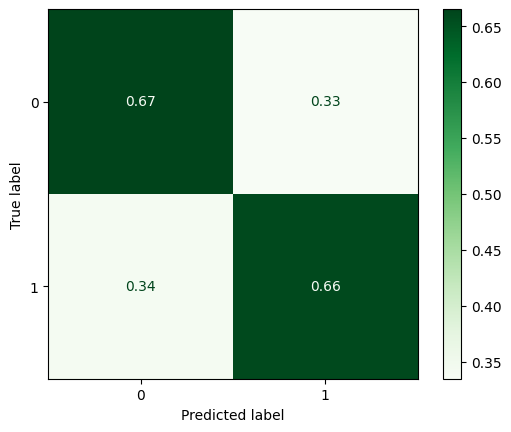

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.590936,0.594963,0.128250,0.130219,0.701561,0.707351,0.216858,0.219947,0.693859,0.698085
LR balanced,0.613078,0.617905,0.131521,0.133420,0.676888,0.679355,0.220247,0.223038,0.692880,0.697400
DecisionTree leaf=100 d=10,0.668238,0.664764,0.152322,0.147407,0.681168,0.659013,0.248969,0.240925,0.737515,0.718092


In [45]:
# define DecisionTree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, class_weight='balanced', random_state=42)

estimators = [step[1] for step in main_pipe.steps]
dt_pipe = make_pipeline(*estimators, RandomUnderSampler(), dt)

model_results,train_pred,test_pred = eval_classification(dt_pipe, X_train, y_train, X_test, y_test, model_name='DecisionTree leaf=100 d=10',
                                    results_frame=model_results)
model_results

### 4. XBGClassifier

Train Evaluation
              precision    recall  f1-score   support

           0       0.97      0.73      0.83    226148
           1       0.19      0.71      0.30     19860

    accuracy                           0.73    246008
   macro avg       0.58      0.72      0.56    246008
weighted avg       0.90      0.73      0.79    246008



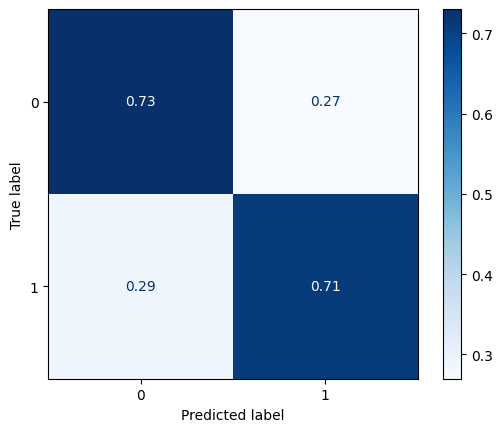

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56538
           1       0.18      0.67      0.28      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.56     61503
weighted avg       0.90      0.72      0.79     61503



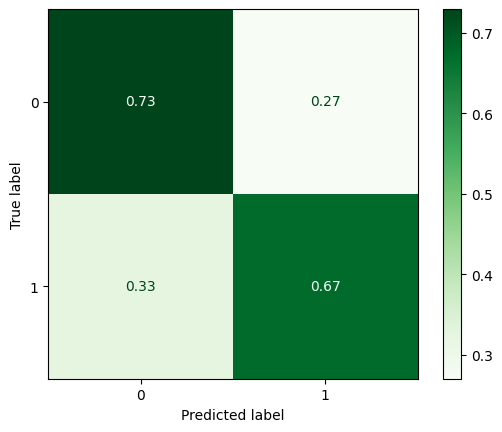

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.590936,0.594963,0.128250,0.130219,0.701561,0.707351,0.216858,0.219947,0.693859,0.698085
LR balanced,0.613078,0.617905,0.131521,0.133420,0.676888,0.679355,0.220247,0.223038,0.692880,0.697400
DecisionTree leaf=100 d=10,0.668238,0.664764,0.152322,0.147407,0.681168,0.659013,0.248969,0.240925,0.737515,0.718092
XGB balanced,0.728647,0.724810,0.187746,0.179253,0.709869,0.673112,0.296953,0.283112,0.796023,0.771132


In [46]:
# define XGBClassifier

xgb = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1, scale_pos_weight=11, random_state=42)

estimators = [step[1] for step in main_pipe.steps]
xgb_pipe = make_pipeline(*estimators, xgb)

model_results,train_pred,test_pred = eval_classification(xgb_pipe, X_train, y_train, X_test, y_test, model_name='XGB balanced',
                                    results_frame=model_results)
model_results

# Check Feature Importances

In [47]:
# check permutation importances

estimators = [step[1] for step in main_pipe.steps]

# lr_model = make_pipeline(*estimators, LogisticRegression(max_iter=1000, class_weight='balanced')).fit(X_train, y_train)
xgb_model = make_pipeline(*estimators, xgb).fit(X_train, y_train)

In [48]:
# use SHAP to evaluate feature importances

X_train_proc = main_pipe.transform(X_train.sample(1000))

# explainer = shap.LinearExplainer(lr_model[-1], X_train_proc)
explainer = shap.Explainer(xgb_model[-1], X_train_proc)
shap_values = explainer(X_train_proc)

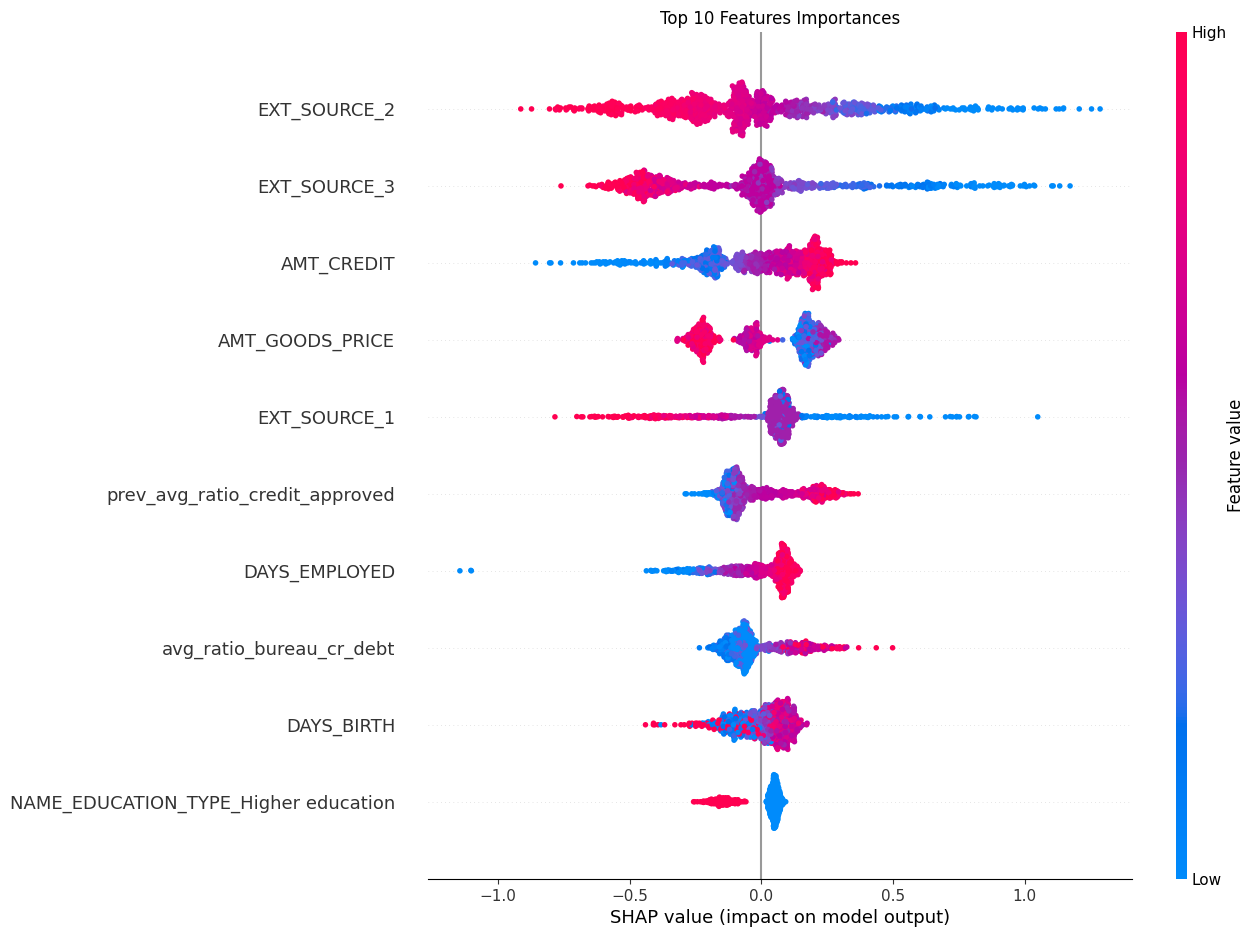

In [49]:
# plot the SHAP summary plot to see the impact of top 50 features

shap.summary_plot(shap_values, X_train_proc, feature_names=X_train_proc.columns, show=False, max_display=10)
plt.gcf().set_size_inches(20,10)
plt.gcf().savefig('shap_plot_10.png', dpi=300)
plt.title('Top 10 Features Importances')
plt.show()

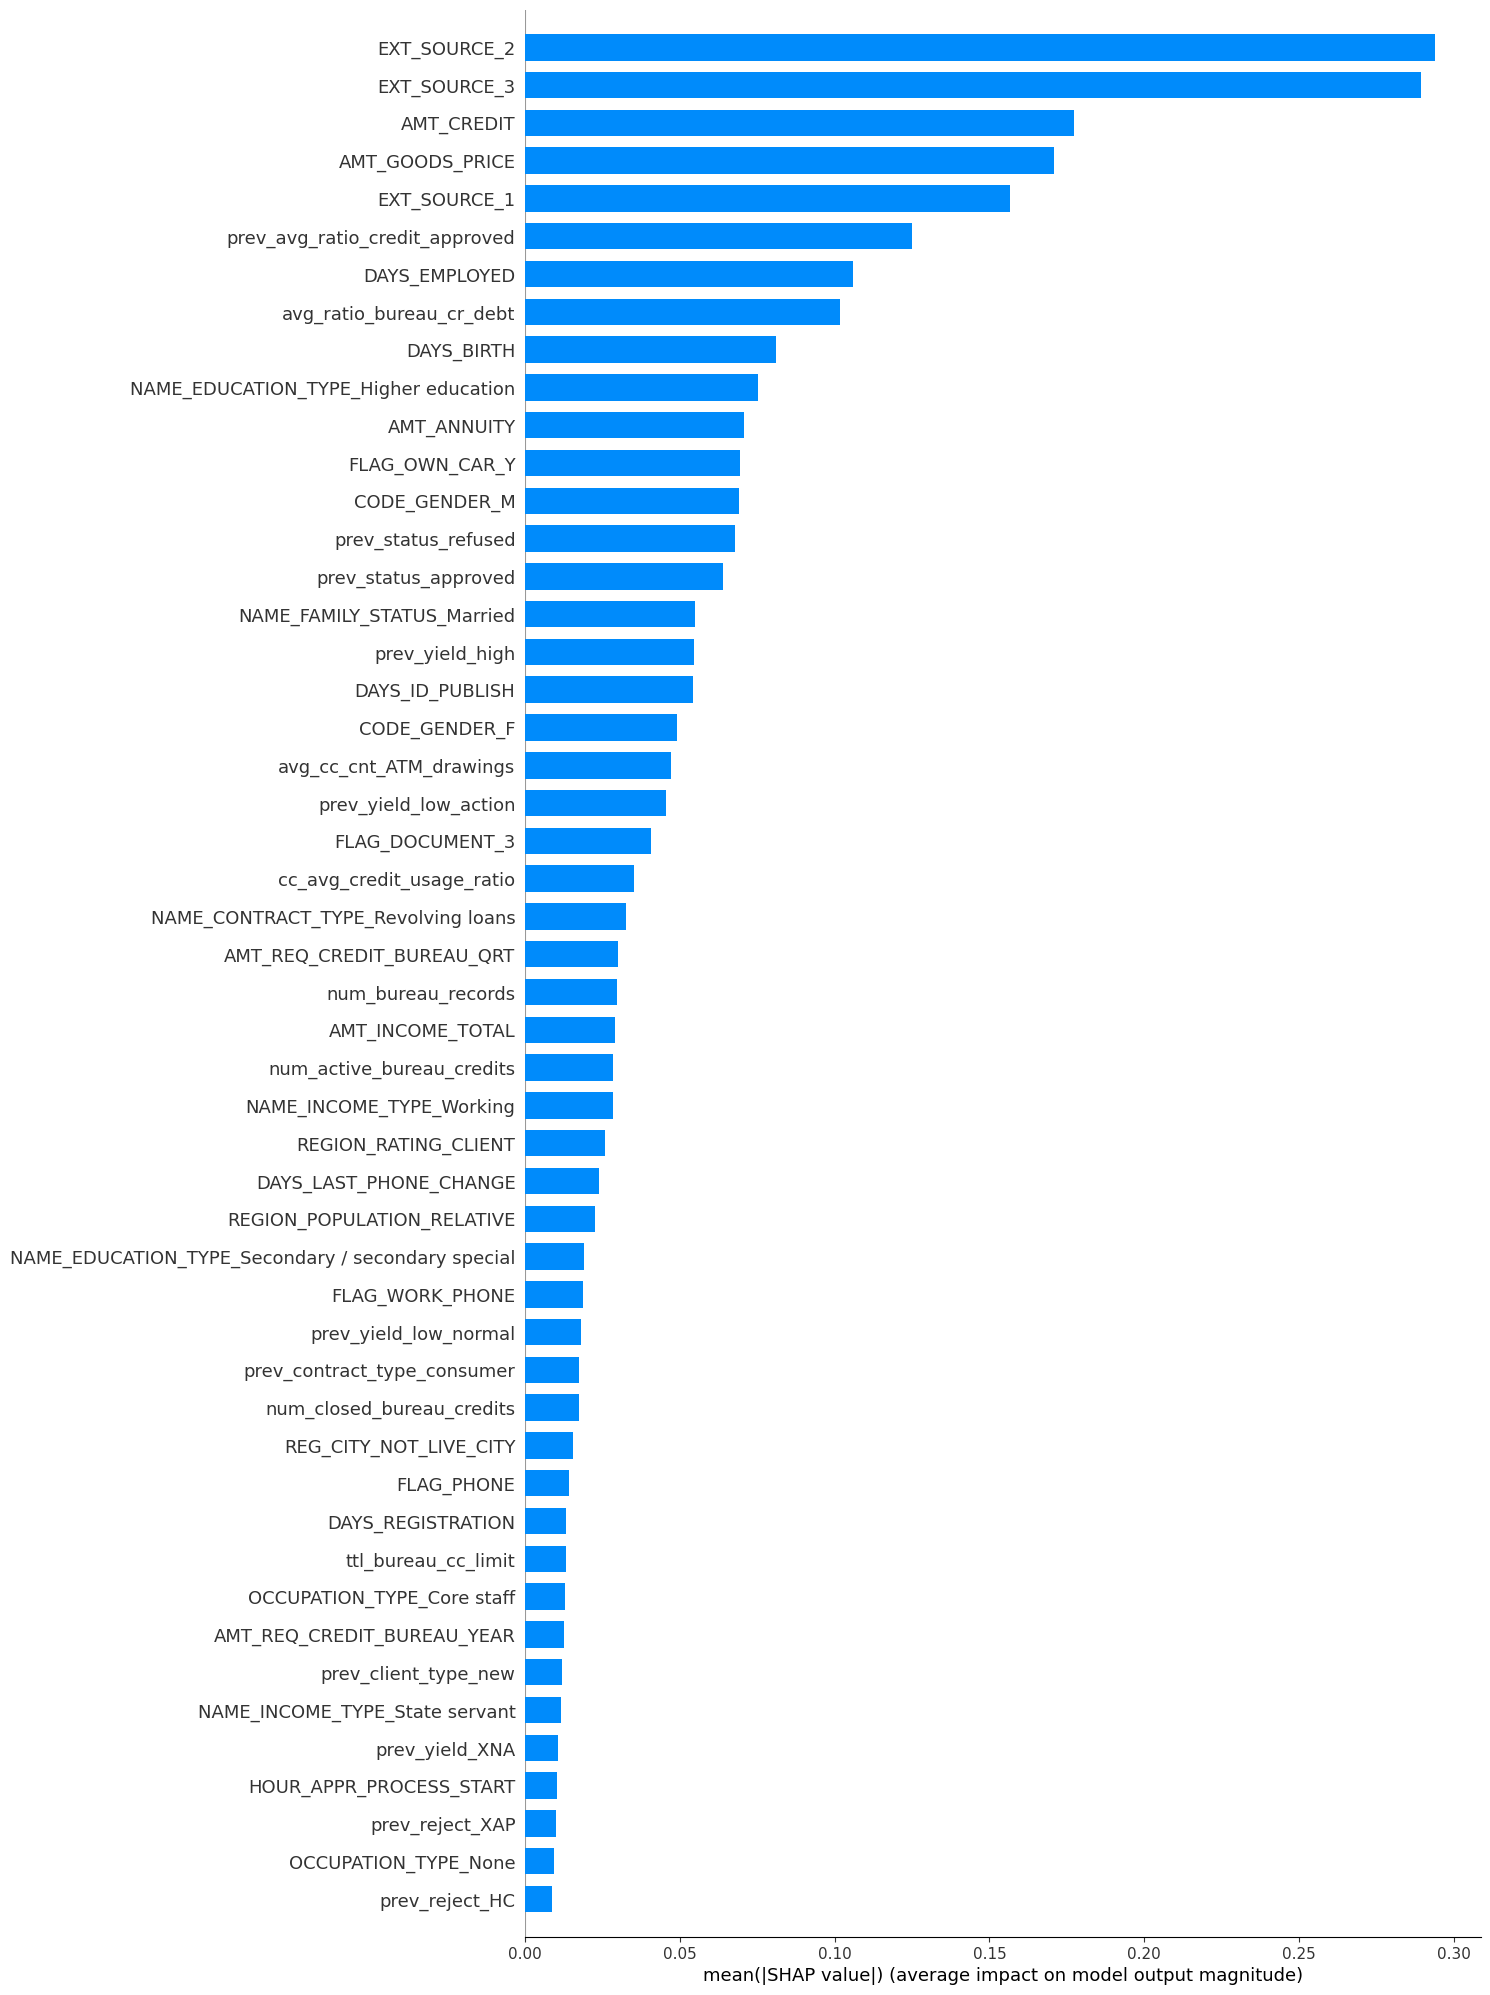

In [50]:
shap.summary_plot(shap_values, X_train_proc, feature_names=X_train_proc.columns, plot_type='bar', max_display=50, show=False)
plt.gcf().set_size_inches(30,20)
plt.show()

In [62]:
# Create a DataFrame with feature importance

feature_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train_proc.columns,
    'importance': feature_importance
})

# get the 20 lowest importances
feature_importance_df.sort_values(by='importance', ascending=True).head(20)

,feature,importance
0,CNT_CHILDREN,0.0
96,FLAG_EMP_PHONE,0.0
40,NAME_FAMILY_STATUS_infrequent_sklearn,0.0
41,NAME_HOUSING_TYPE_Co-op apartment,0.0
30,NAME_EDUCATION_TYPE_Academic degree,0.0
29,NAME_INCOME_TYPE_infrequent_sklearn,0.0
100,REG_REGION_NOT_LIVE_REGION,0.0
23,"NAME_TYPE_SUITE_Spouse, partner",0.0
22,NAME_TYPE_SUITE_Other_B,0.0
20,NAME_TYPE_SUITE_Group of people,0.0


# Use a permutation importance mask to remove features

In [52]:
# transform train and test

X_train_processed = main_pipe.transform(X_train)
X_test_processed = main_pipe.transform(X_test)

# get the permutation importances

importances = permutation_importance(xgb, X_train_processed, y_train, random_state=42, scoring='roc_auc')


In [53]:
# put the importances in a Series

importances_df = pd.DataFrame(importances.importances_mean, index=X_train_processed.columns)
importances_df.columns = ['importance']
importances_df

,importance
CNT_CHILDREN,0.000000
AMT_INCOME_TOTAL,0.001829
AMT_CREDIT,0.013839
AMT_ANNUITY,0.005269
AMT_GOODS_PRICE,0.011253
...,...
AMT_REQ_CREDIT_BUREAU_QRT,0.000992
AMT_REQ_CREDIT_BUREAU_YEAR,0.000532
EXT_SOURCE_2,0.043307
EXT_SOURCE_1,0.016548


In [54]:
importances_df.sort_values(by='importance', ascending=False)

,importance
EXT_SOURCE_2,0.043307
EXT_SOURCE_3,0.037151
EXT_SOURCE_1,0.016548
AMT_CREDIT,0.013839
AMT_GOODS_PRICE,0.011253
...,...
NAME_INCOME_TYPE_infrequent_sklearn,0.000000
NAME_HOUSING_TYPE_With parents,0.000000
prev_contract_type_XNA,0.000000
NAME_FAMILY_STATUS_infrequent_sklearn,0.000000


In [55]:
imp_mask = importances_df['importance'] > 0.001
imp_mask.value_counts()

importance
False    104
True      31
Name: count, dtype: int64

In [56]:
X_train_imp = X_train_processed.loc[:, imp_mask]
X_test_imp = X_test_processed.loc[:, imp_mask]

X_train_imp

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Revolving loans,...,prev_avg_ratio_credit_approved,prev_status_approved,prev_status_refused,prev_yield_high,prev_yield_low_action,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,EXT_SOURCE_2,EXT_SOURCE_1,EXT_SOURCE_3
181648,-1.026723,-1.028179,-1.062115,-1.202702,0.855291,0.399369,-0.393927,-1.111106,-0.102783,0.0,...,1.024200,5.0,0.0,2.0,0.0,0.0,1.0,0.289573,0.384582,0.622922
229245,-1.026723,-1.505288,-1.075278,-1.604903,0.150020,0.760073,1.049094,0.663110,1.862347,0.0,...,1.056443,4.0,1.0,0.0,0.0,-509.0,1.0,0.514261,0.505446,0.535276
122525,-0.196844,0.599266,0.201767,0.367767,-0.751224,0.103710,-0.840225,0.100877,1.862347,0.0,...,0.929718,1.0,0.0,1.0,0.0,-1474.0,1.0,0.486906,0.505446,0.598926
306311,-0.196844,-0.001641,0.705330,-0.116355,-0.403745,0.101598,1.122579,1.093404,-0.102783,0.0,...,1.082621,6.0,2.0,3.0,0.0,-2016.0,1.0,0.675705,0.505446,0.454321
300658,0.391966,-0.870432,0.286815,-0.890730,1.729030,0.386275,0.600526,1.420268,-0.102783,0.0,...,0.995030,1.0,1.0,1.0,0.0,-695.0,1.0,0.154565,0.505446,0.535276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31304,-0.196844,-0.222095,-0.277274,-0.068958,0.150249,0.547621,-0.522454,-0.945353,-0.102783,1.0,...,0.900000,1.0,0.0,1.0,0.0,-379.0,0.0,0.549668,0.505446,0.535276
121193,0.118662,-0.775899,-0.165241,-0.890730,-0.688879,-1.031621,-0.993152,0.287183,-0.102783,0.0,...,0.988756,4.0,5.0,3.0,1.0,-374.0,1.0,0.569702,0.505446,0.600658
248504,-1.026723,-0.916987,0.071009,-0.835896,-1.617857,0.953096,-1.130759,-1.088564,-0.102783,0.0,...,1.046073,4.0,0.0,0.0,3.0,-1689.0,0.0,0.461966,0.505446,0.683269
175469,-0.570008,0.746841,0.242642,0.900118,-1.402402,0.953096,-1.467539,-1.088564,1.862347,0.0,...,1.067220,5.0,2.0,0.0,0.0,-1329.0,1.0,0.459173,0.505446,0.812823


In [57]:
from sklearn.model_selection import cross_validate

cross_validate(xgb, X_train_imp, y_train, cv=5, scoring='roc_auc', return_train_score=True)

{'fit_time': array([0.65721488, 0.63905907, 0.56756806, 0.58817816, 0.60283685]),
 'score_time': array([0.02113819, 0.02103806, 0.02333283, 0.02369785, 0.02306604]),
 'test_score': array([0.77113255, 0.75447898, 0.76840678, 0.76942906, 0.76664481]),
 'train_score': array([0.79801292, 0.8006899 , 0.79730966, 0.79825903, 0.79842207])}

# Predict Test

In [58]:
# import test data
kaggle_test = pd.read_csv('../data/merged_test.csv')

# save the id column
kaggle_columns = kaggle_test['SK_ID_CURR']

# process kaggle data
kaggle_proc = main_pipe.transform(kaggle_test)
kaggle_proc_masked = kaggle_proc.loc[:,imp_mask]
kaggle_proc_masked

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Revolving loans,...,prev_avg_ratio_credit_approved,prev_status_approved,prev_status_refused,prev_yield_high,prev_yield_low_action,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,EXT_SOURCE_2,EXT_SOURCE_1,EXT_SOURCE_3
0,-0.196844,0.252683,-0.249418,0.078345,-0.736096,-0.184769,-0.051188,1.446789,-0.102783,0.0,...,0.957782,1.0,0.0,1.0,0.0,-1740.0,1.0,0.789654,0.752614,0.159520
1,-0.831649,-1.057685,-0.558110,-1.202702,-0.466319,-1.088640,-1.171331,0.909087,-0.102783,0.0,...,0.899950,1.0,0.0,1.0,0.0,0.0,1.0,0.291656,0.564990,0.432962
2,0.633037,0.467459,1.987530,0.548760,-0.918774,-1.083994,0.798566,-0.337373,-0.102783,0.0,...,1.052363,3.0,0.0,1.0,0.0,-856.0,0.0,0.699787,0.505446,0.610991
3,1.537355,1.676398,1.341103,1.829810,0.470681,0.010788,0.848217,-0.804795,-0.102783,0.0,...,0.975609,3.0,0.0,0.0,1.0,-1805.0,1.0,0.509677,0.525734,0.612704
4,0.391966,0.385513,0.564222,0.538738,0.685219,-0.126482,0.280769,-0.840598,-0.102783,0.0,...,1.131358,1.0,0.0,1.0,0.0,-821.0,1.0,0.425687,0.202145,0.535276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,-0.412489,-0.196242,-0.547234,-0.635830,-0.903188,-1.384299,-1.164522,-0.268420,1.862347,0.0,...,1.132000,1.0,0.0,0.0,0.0,-684.0,0.0,0.648575,0.505446,0.643026
48740,0.118662,0.378597,0.555208,0.211596,1.110170,0.313628,0.560237,-0.005867,-0.102783,0.0,...,1.096814,4.0,0.0,3.0,1.0,0.0,1.0,0.684596,0.505446,0.535276
48741,0.633037,-0.573402,0.628090,-0.420315,0.024643,-0.483807,0.655001,0.987986,-0.102783,0.0,...,0.949988,2.0,0.0,0.0,0.0,-838.0,1.0,0.632770,0.733503,0.283712
48742,0.848683,-0.074814,0.117828,0.078345,0.472515,-0.354562,1.001145,1.080807,-0.102783,0.0,...,1.102514,2.0,2.0,3.0,0.0,-2308.0,1.0,0.445701,0.373090,0.595456


In [59]:
# predict kaggle

xgb_imp = xgb.fit(X_train_imp, y_train)
kaggle_preds = xgb_imp.predict(kaggle_proc_masked)

# save the prediction into the kaggle format and check values

prediction_df = pd.DataFrame({'SK_ID_CURR': kaggle_columns,'TARGET': kaggle_preds})
prediction_df

,SK_ID_CURR,TARGET
0,100001,0
1,100005,1
2,100013,0
3,100028,0
4,100038,1
...,...,...
48739,456221,0
48740,456222,0
48741,456223,0
48742,456224,1


In [60]:
# check the class balance of the predictions

prediction_df['TARGET'].value_counts()

TARGET
0    33592
1    15152
Name: count, dtype: int64

In [63]:
# export predictions to submission csv

prediction_df.to_csv('../submissions/submission12_xgb_31features.csv', index=False)